# Time Series Exploration

In [123]:
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import janitor 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.model_selection import SlidingWindowForecastCV
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
reports_shp = gpd.read_file('modified_data/augmented_311.shp')

In [6]:
reports = reports_shp.drop(columns='geometry')

In [35]:
reports.columns

Index(['service_re', 'sap_notifi', 'date_reque', 'case_age_d', 'case_recor',
       'service_na', 'date_close', 'status', 'lat', 'lng', 'street_add',
       'zipcode', 'council_di', 'comm_plan_', 'comm_pla_1', 'park_name',
       'case_origi', 'referred', 'iamfloc', 'floc', 'public_des', 'prop_upper',
       'clean_text', 'word_count', 'index_righ', 'lu', 'DESCRIPTIO',
       'Shape_Leng', 'Shape_Area', 'land_use_b', 'in_park'],
      dtype='object')

In [11]:
reports.date_reque.unique()

<DatetimeArray>
['2020-01-19 00:00:00', '2020-01-20 00:00:00', '2020-01-21 00:00:00',
 '2020-01-22 00:00:00', '2020-01-23 00:00:00', '2020-01-24 00:00:00',
 '2020-01-25 00:00:00', '2020-01-26 00:00:00', '2020-01-27 00:00:00',
 '2020-01-28 00:00:00',
 ...
 '2020-12-27 00:00:00', '2020-12-28 00:00:00', '2020-12-29 00:00:00',
 '2020-12-30 00:00:00', '2020-12-31 00:00:00', '2020-12-18 00:00:00',
 '2020-12-19 00:00:00', '2020-12-20 00:00:00', '2020-12-21 00:00:00',
                 'NaT']
Length: 494, dtype: datetime64[ms]

In [ ]:
# 88 of the dates are NAs?
len(reports[reports['date_reque'].isna()])/len(reports['date_reque'])

0.888447636950631

In [14]:
reports[reports['date_reque'].isna()]


,service_re,sap_notifi,date_reque,case_age_d,case_recor,service_na,date_close,status,lat,lng,...,prop_upper,clean_text,word_count,index_righ,lu,DESCRIPTIO,Shape_Leng,Shape_Area,land_use_b,in_park
26882,NaN,None,NaT,NaN,None,None,NaT,Closed,32.714723,-117.156506,...,NaN,None,0,86733.0,4118.0,Road Right of Way,2.450778e+06,8.410296e+07,Transportation,0
26883,NaN,None,NaT,NaN,None,None,NaT,Closed,32.751725,-117.066742,...,NaN,None,0,86744.0,4118.0,Road Right of Way,2.785856e+06,8.541848e+07,Transportation,0
26884,NaN,None,NaT,NaN,None,None,NaT,Closed,32.783246,-117.106744,...,NaN,None,0,61838.0,1120.0,Single Family Multiple-Units,5.095629e+03,6.486805e+05,Residential,0
26885,NaN,None,NaT,NaN,None,None,NaT,Closed,32.721867,-117.169497,...,NaN,None,0,86733.0,4118.0,Road Right of Way,2.450778e+06,8.410296e+07,Transportation,0
26886,NaN,None,NaT,NaN,None,None,NaT,Closed,32.765920,-117.204337,...,NaN,None,0,81493.0,2101.0,Industrial Park,1.936578e+03,1.264239e+05,Industrial,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240976,NaN,None,NaT,NaN,None,None,NaT,Closed,32.588528,-117.048648,...,NaN,None,0,100819.0,7603.0,Open Space Park or Preserve,2.775179e+04,1.045354e+07,Rec / Open Space,0
240977,NaN,None,NaT,NaN,None,None,NaT,Closed,32.737629,-117.161356,...,NaN,None,0,86734.0,4118.0,Road Right of Way,7.973632e+05,2.547860e+07,Transportation,0
240978,NaN,None,NaT,NaN,None,None,NaT,Closed,32.728338,-117.153042,...,NaN,None,0,97290.0,6109.0,Other Public Services,1.657442e+03,1.101234e+05,Institutional,1
240979,NaN,None,NaT,NaN,None,None,NaT,Closed,32.718409,-117.153935,...,NaN,None,0,90267.0,5007.0,Arterial Commercial,5.590350e+02,1.796754e+04,Commercial,0


In [36]:
reports_clean = reports.dropna(subset=['date_reque'])
len(reports_clean)


26882

Time Series Plot

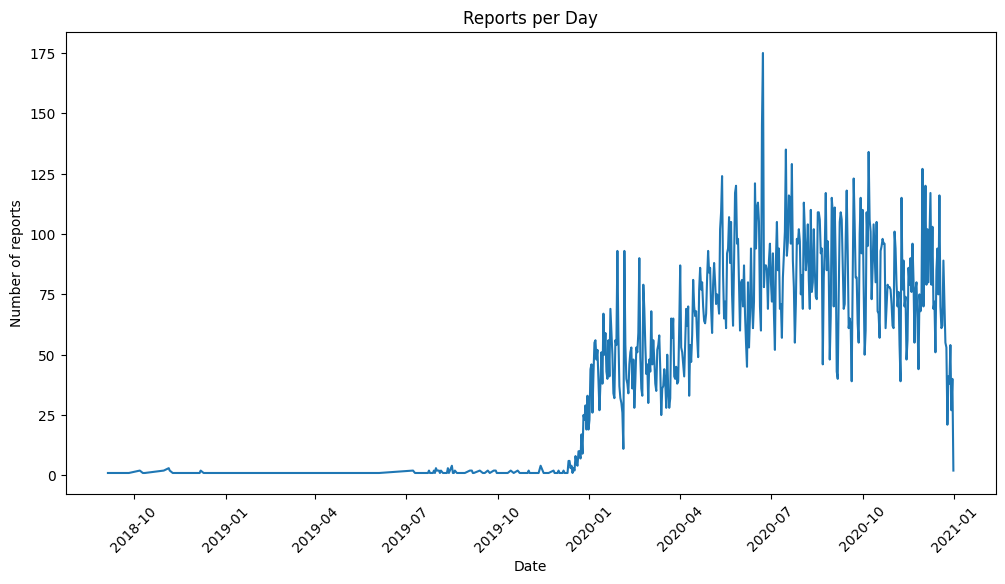

In [84]:
report_counts = reports_clean.groupby('date_reque').size().reset_index(name='n')
report_counts.set_index("date_reque", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(report_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day")
plt.xticks(rotation=45)
plt.show()

### Check for Autocorrelation

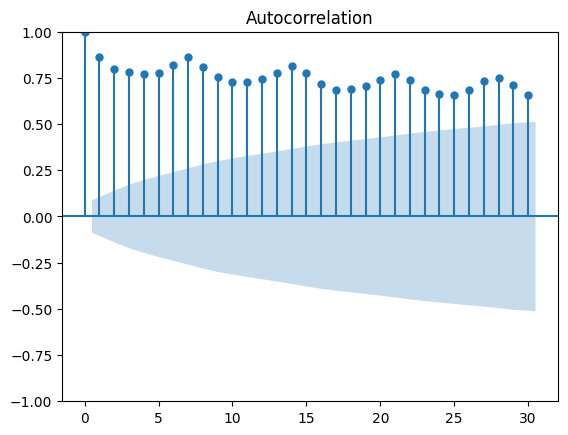

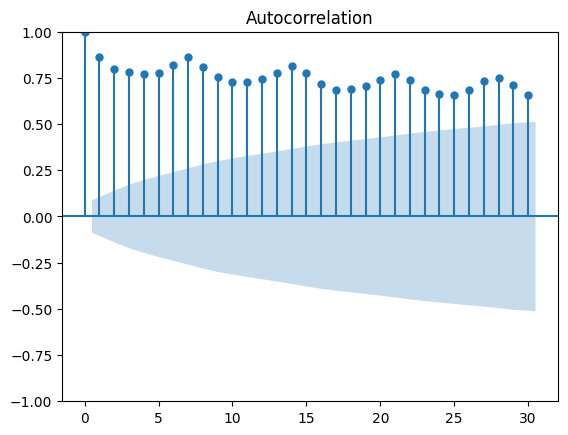

In [38]:
# approx monthly
plot_acf(report_counts['n'], lags=30)

We can see weekly seasonality

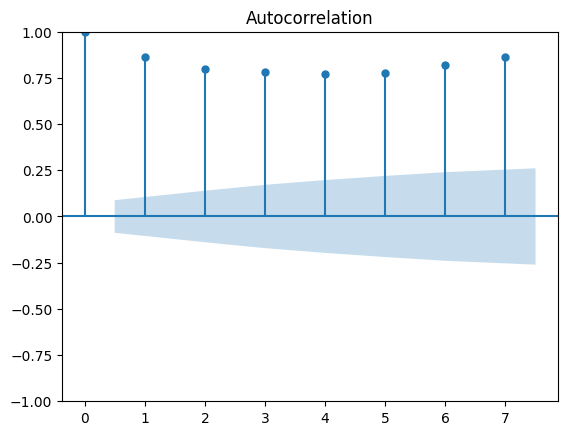

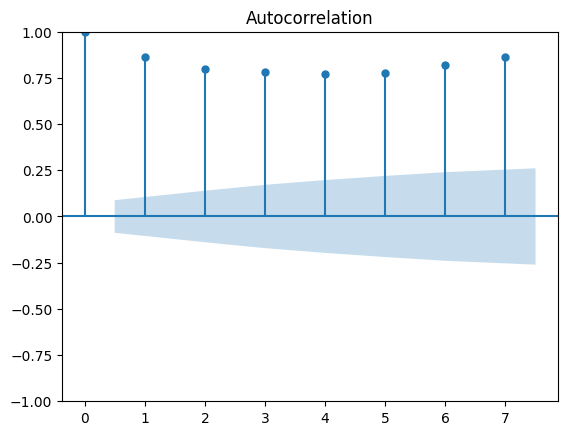

In [85]:
# approx weekly
plot_acf(report_counts['n'], lags=7)

### Testing for Stationarity with the ADF Test

In [44]:
adf_res = adfuller(report_counts['n'])
print('ADF statistic:', adf_res[0])
print('p-val', adf_res[1]),
print('Critival values', adf_res[4])

ADF statistic: -1.651422179246783
p-val 0.45629882192987414
Critival values {'1%': np.float64(-3.444162847239118), '5%': np.float64(-2.8676311169658177), '10%': np.float64(-2.5700143303792107)}


Based on our large p-value, we fail to reject the null hypothesis that the data is non-stationary. Thus we conclude that our time series is non-stationary, meaning that differncing or other transformations may be needed to achieve stationarity before applying certain time series models (like an (S)ARIMA model).

### Differencing to achieve stationarity
Subtracrts the previous observation from the current observation to remove trends and/or seasonality

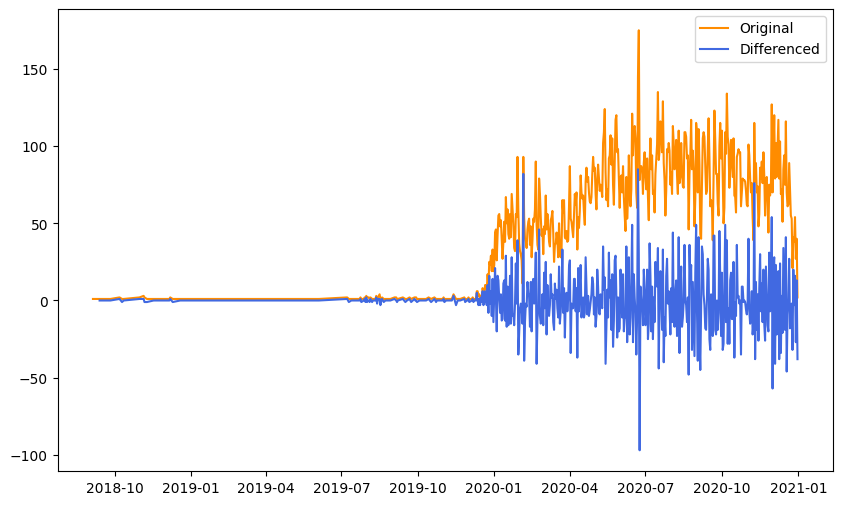

In [90]:
report_counts['n_diff'] = report_counts['n'].diff()
plt.figure(figsize=(10, 6))
plt.plot(report_counts['n'], label = "Original", color="darkorange")
plt.plot(report_counts['n_diff'], label = "Differenced", color="royalblue")
plt.legend()

In [64]:
combined = pd.concat([report_counts['n'], report_counts['n_diff']], axis=1)
combined

,n,n_diff
0,1,NaN
1,1,0.0
2,1,0.0
3,2,1.0
4,1,-1.0
...,...,...
488,38,-3.0
489,54,16.0
490,27,-27.0
491,40,13.0


### Smoothing Data with a Moving Average

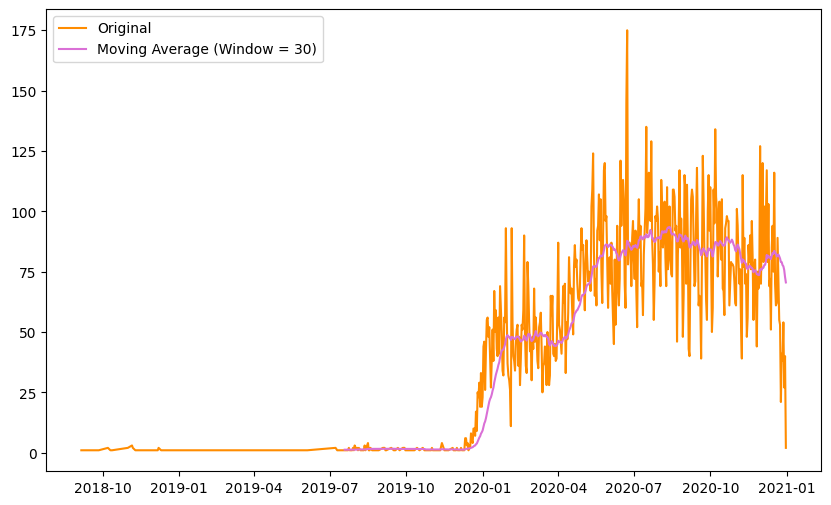

In [89]:
# window = number of consecutive data points averaged
window_size = 30 # this can be adjusted,
report_counts['n_smoothed'] = report_counts['n'].rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(report_counts['n'], label = "Original", color = "darkorange")
plt.plot(report_counts['n_smoothed'], label = f'Moving Average (Window = {window_size})', color = "orchid")
plt.legend()

### ADF test to compare original vs differenced

In [91]:
report_counts.dropna(subset=['n_diff'], inplace=True)
report_counts.head()

,n,n_diff,n_smoothed
date_reque,,,
2018-09-13,1,0.0,NaN
2018-09-26,1,0.0,NaN
2018-10-07,2,1.0,NaN
2018-10-10,1,-1.0,NaN
2018-10-12,1,0.0,NaN


In [92]:
adf_res = adfuller(report_counts['n_diff'])
print('ADF statistic:', adf_res[0])
print('p-val', adf_res[1]),
print('Critical values', adf_res[4])

ADF statistic: -5.2701233853285565
p-val 6.312348254244525e-06
Critical values {'1%': np.float64(-3.444162847239118), '5%': np.float64(-2.8676311169658177), '10%': np.float64(-2.5700143303792107)}


According to our small p-value, we reject the null hypothesis that we have non-stationarity. We have enough evidence to conclude that we now have stationary data after differencing. 

## Time for model selection!

### ACF/PACF of stationary data 

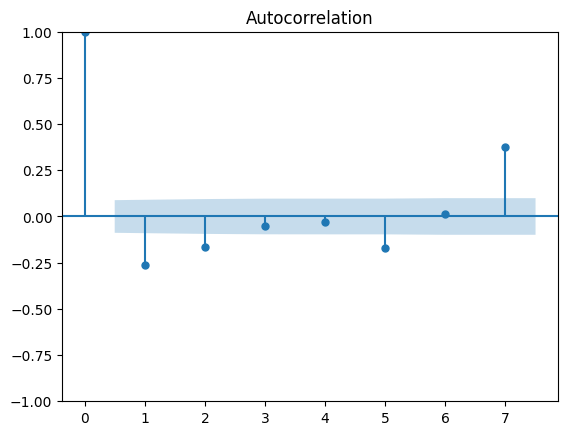

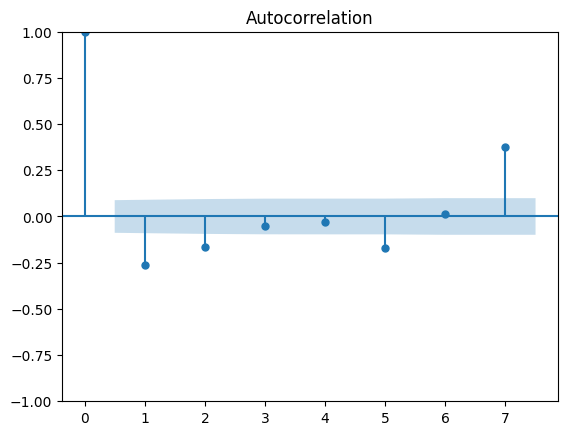

In [76]:
plot_acf(report_counts['n_diff'], lags=7)

The ACF shows a significant correlation at lag 7

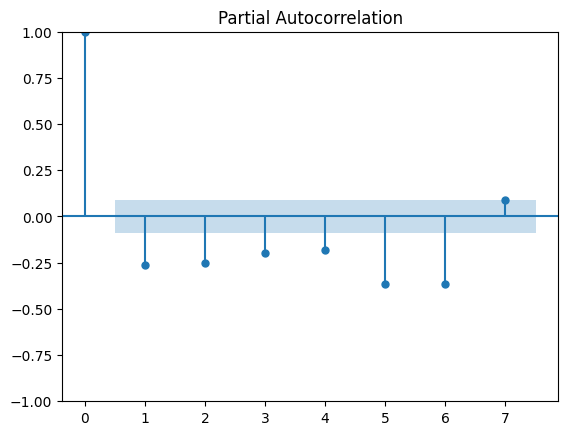

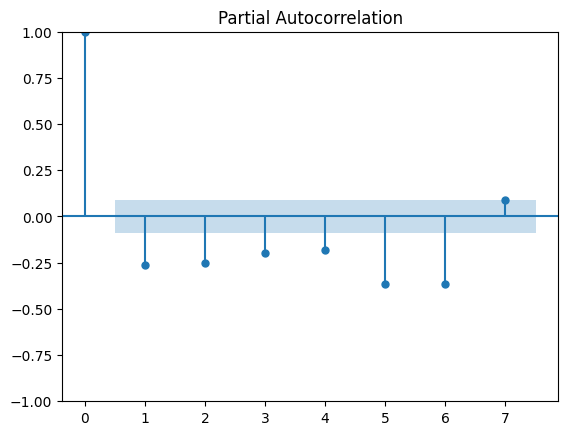

In [79]:
plot_pacf(report_counts['n_diff'], lags=7)

Looks like there might still be seasonal dependence (by week) for number of reports. So, an SARIMA model might make sense in this case

### Using an automated algorithm to find best ARIMA model (no seasonality)

In [110]:
y = report_counts['n'].values
model_arima = pm.auto_arima(y, seasonal=False, suppress_warnings=True, stepwise=True)

model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  492
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2013.420
Date:                Mon, 17 Nov 2025   AIC                           4042.841
Time:                        10:24:05   BIC                           4076.412
Sample:                             0   HQIC                          4056.024
                                - 492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4719      0.036     13.201      0.000       0.402       0.542
ar.L2         -0.6685      0.038    -17.432      0.000      -0.744      -0.593
ar.L3         -0.2697      0.051     -5.292      0.000      -0.370      -0.170
ar.L4         -0.2675      0.042     -6.327      0.000      -0.350      -0.185
ar.L5         -0.2811      0.041     -6.817      0.000      -0.362      -0.200
ma.L1         -1.1432      0.026    -43.854      0.000      -1.194      -1.092
ma.L2          0.8864      0.022     39.826      0.000       0.843       0.930
sigma2       212.8561      9.997     21.292      0.000     193.262     232.450
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                97.96
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:

model_sarima = pm.auto_arima(y, seasonal=True, m=7, suppress_warnings=True, stepwise=True)

model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  492
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -1997.726
Date:                             Mon, 17 Nov 2025   AIC                           4009.452
Time:                                     10:24:42   BIC                           4038.827
Sample:                                          0   HQIC                          4020.988
                                             - 492                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8646      0.066     13.092      0.000       0.735       0.994
ma.L1         -1.5534      0.082    -18.948      0.000      -1.714      -1.393
ma.L2          0.5669      0.073      7.752      0.000       0.424       0.710
ar.S.L7        1.0858      0.066     16.455      0.000       0.956       1.215
ar.S.L14      -0.1040      0.059     -1.766      0.077      -0.219       0.011
ma.S.L7       -0.8658      0.049    -17.805      0.000      -0.961      -0.770
sigma2       197.5870      8.892     22.220      0.000     180.158     215.016
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               132.14
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.03   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMA model has a lower AIC, so let's go with that.

Our chosen model is SARIMA(1,1,2, 1,1,7)

* AR(1)
    - Number of reports on current day depends partly on the value from the previous day
* I(1)
    - It took one difference (like we saw above) to make the data stationary
* MA(2)
    - Errors from the last two days influence the current day's number of reports
* Seasonal AR(2)
    - The current day depnds on the number of reports one and two weeks ago
* Seasonal I (differencing) = 0
    - No weekly differencing needed
* Seasonal MA(1)
    - Errors from one week ago influence the current day
* Seaonality period = 7

### Check if the residuals of the chosen model are white noise

In [130]:
# fit the mode
residuals = model_sarima.resid()

Plot the residuals

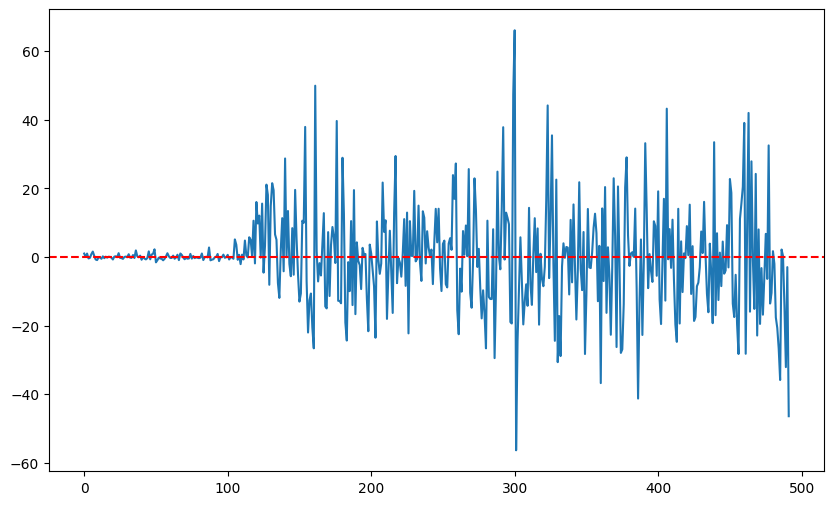

In [131]:
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.axhline(0, color = "red", linestyle= '--')

ACF plot (looks good)

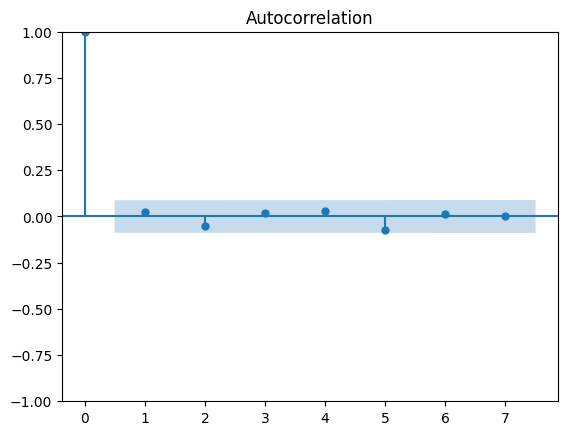

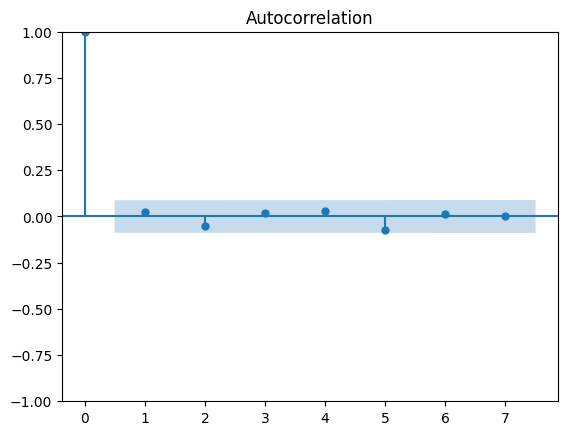

In [132]:
plot_acf(residuals, lags=7)

PACF plot (looks good)

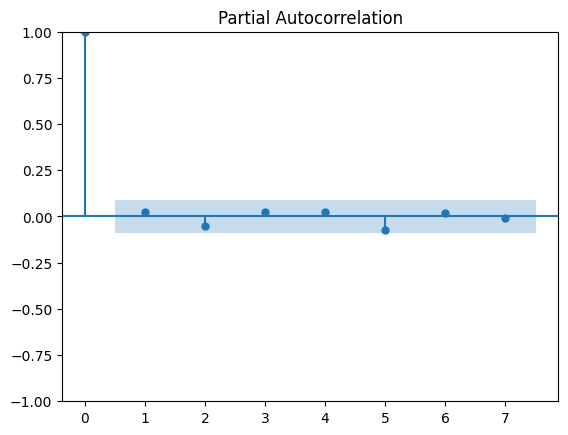

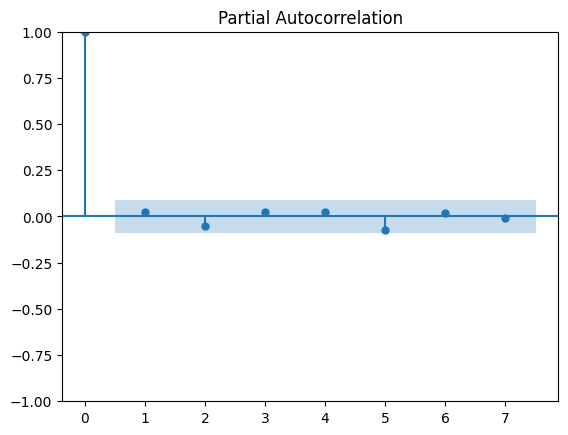

In [133]:
plot_pacf(residuals, lags=7)

Formal test for white noise (Ljung-Box test)

$H_0$: residuals are independently distributed

$H_A$: residuals are independently distributed

In [136]:
lb_test = acorr_ljungbox(residuals, lags=[7, 14, 21, 28], return_df=True)
lb_test

,lb_stat,lb_pvalue
7,5.061342,0.652477
14,7.165916,0.928126
21,20.150495,0.511747
28,34.813633,0.175358


At one, two, three, and four weeks, we can conclude that the residuals are independently distributed!